In [ ]:
!pip install stop-words

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=44c3867bb16abe681b8a52972e20ad8d73c0fe75fd4dc07d839d6b3b91671382
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
import string
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

from nltk.corpus import words
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from stop_words import get_stop_words
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import wordnet
import torch
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification
)

from torch.optim import AdamW
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers_interpret import SequenceClassificationExplainer
from lime.lime_text import LimeTextExplainer
from IPython.core.display import display, HTML
import gc
from collections import defaultdict
from datetime import datetime
import json

random.seed(42)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


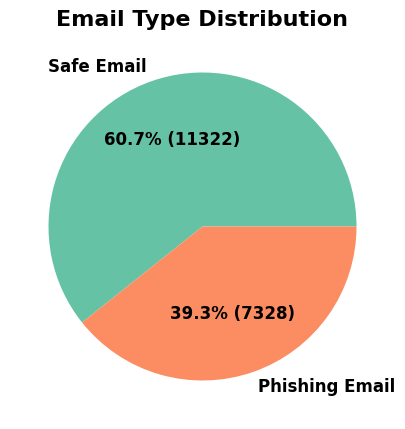

Email Text     True
Email Type    False
Label         False
dtype: bool
-------------------------------
Email Text    16
Email Type     0
Label          0
dtype: int64
After removing null values:
Email Text    False
Email Type    False
Label         False
dtype: bool
-------------------------------
Email Text    0
Email Type    0
Label         0
dtype: int64
New Data length:  18634


,Email_Text,Email Type,Label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,hello i am your hot lil horny toy. i am the on...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


In [ ]:
df = pd.read_csv('Phishing_Email.csv')
df.head()

df['Label'] = df['Email Type'].apply(lambda x: 1 if x=='Phishing Email' else 0)
df = df.drop('Unnamed: 0', axis=1)
df['Email Type'].value_counts()
df.head()

# Data Distribution
email_type_counts = df['Email Type'].value_counts()

plt.figure(figsize=(5, 5))
colors = ['#66c2a5' if label == 'Safe Email' else '#fc8d62' for label in email_type_counts.index]
plt.pie(email_type_counts, labels=email_type_counts.index,
        autopct=lambda p: f'{p:.1f}% ({int(p * sum(email_type_counts) / 100)})',
        textprops={'fontsize': 12, 'fontweight': 'bold'}, colors=colors)
plt.title('Email Type Distribution', fontsize=16, fontweight='bold')
plt.savefig('email_type_pie_chart.jpg', dpi=600)
plt.show()

# Remove rows with null values
print(df.isnull().any())
print('-------------------------------')
print(df.isnull().sum())

if df.isnull().values.any():
    df = df.dropna()
    print('After removing null values:')
    print(df.isnull().any())
    print('-------------------------------')
    print(df.isnull().sum())
else:
    print('No null values found.')

print("New Data length: ", len(df))
df['Email Type'].value_counts()

# Preprocessing
def clean_text(text):
    text = text.lower()
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\r', ' ')
    text = text.strip()
    return text

def preprocess_text(text):
    return clean_text(text)

df['Email_Text'] = df['Email Text'].apply(preprocess_text)
df.head(5)

data = df[['Email_Text', 'Email Type', 'Label']]
data.head(5)

In [ ]:
# Synonym Replacement Function
stop_words = set(stopwords.words('english'))

def synonym_replacement(text, replace_ratio=0.2):
    words = text.split()
    new_words = words[:]
    non_stop_indices = [i for i, word in enumerate(words) if word.lower() not in stop_words]
    num_replacements = max(1, int(len(non_stop_indices) * replace_ratio))

    if not non_stop_indices:
        return text

    indices_to_replace = random.sample(non_stop_indices, min(num_replacements, len(non_stop_indices)))

    for idx in indices_to_replace:
        word = words[idx]
        synonyms = wordnet.synsets(word)
        valid_synonyms = [
            lemma.name().replace('_', ' ')
            for syn in synonyms
            for lemma in syn.lemmas()
            if lemma.name().lower() != word.lower()
        ]
        if valid_synonyms:
            synonym = random.choice(valid_synonyms)
            new_words[idx] = synonym

    return ' '.join(new_words)

def augment_phishing_data(email_text, replace_ratio=0.2):
    return synonym_replacement(email_text, replace_ratio)

In [ ]:
# Split dataset
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    data['Email_Text'],
    data['Email Type'],
    test_size=0.2,
    random_state=42,
    stratify=data['Email Type']
)

print("After initial split:")
print(f"Train+Val size: {len(train_val_texts)}")
print(f"Test size: {len(test_texts)}")
print("\nTest set distribution:")
print(test_labels.value_counts())

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_val_labels
)

print("After train-val split:")
print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

print("\nClass distribution before augmentation:")
print("Training set:")
print(train_labels.value_counts())
print("\nValidation set:")
print(val_labels.value_counts())
print("\nTest set:")
print(test_labels.value_counts())

# Create balanced training set
train_df = pd.DataFrame({
    'Email_Text': train_texts.reset_index(drop=True),
    'Email Type': train_labels.reset_index(drop=True)
})

phishing_train = train_df[train_df['Email Type'] == 'Phishing Email'].copy()
non_phishing_train = train_df[train_df['Email Type'] == 'Safe Email'].copy()

majority_count = len(non_phishing_train)
minority_count = len(phishing_train)
samples_to_generate = majority_count - minority_count

print(f"Phishing emails in training: {minority_count}")
print(f"Safe emails in training: {majority_count}")
print(f"Samples to generate: {samples_to_generate}")

augmented_samples = []

if samples_to_generate > 0:
    while len(augmented_samples) < samples_to_generate:
        for index, row in phishing_train.iterrows():
            email_text = row['Email_Text']
            augmented_text = augment_phishing_data(email_text)
            augmented_samples.append({
                'Email_Text': augmented_text,
                'Email Type': row['Email Type'],
            })
            if len(augmented_samples) >= samples_to_generate:
                break

    augmented_df = pd.DataFrame(augmented_samples)
    balanced_train_df = pd.concat([train_df, augmented_df], ignore_index=True)
    balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
else:
    balanced_train_df = train_df

print("\nAfter augmentation:")
print("Balanced training set distribution:")
print(balanced_train_df['Email Type'].value_counts())
print(f"Final training set size: {len(balanced_train_df)}")

final_train_texts = balanced_train_df['Email_Text']
final_train_labels = balanced_train_df['Email Type']

val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

print("Final dataset sizes:")
print(f"Training: {len(final_train_texts)}")
print(f"Validation: {len(val_texts)}")
print(f"Test: {len(test_texts)}")


After initial split:
Train+Val size: 14907
Test size: 3727

Test set distribution:
Email Type
Safe Email        2265
Phishing Email    1462
Name: count, dtype: int64
After train-val split:
Train size: 11925
Validation size: 2982
Test size: 3727

Class distribution before augmentation:
Training set:
Email Type
Safe Email        7245
Phishing Email    4680
Name: count, dtype: int64

Validation set:
Email Type
Safe Email        1812
Phishing Email    1170
Name: count, dtype: int64

Test set:
Email Type
Safe Email        2265
Phishing Email    1462
Name: count, dtype: int64
Phishing emails in training: 4680
Safe emails in training: 7245
Samples to generate: 2565

After augmentation:
Balanced training set distribution:
Email Type
Phishing Email    7245
Safe Email        7245
Name: count, dtype: int64
Final training set size: 14490
Final dataset sizes:
Training: 14490
Validation: 2982
Test: 3727


## **RANDOM SEARCH HYPERPARAMETER TUNING**

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

print("\n" + "="*70)
print("RANDOM SEARCH HYPERPARAMETER TUNING")
print("="*70)

# Define Parameter Search Range
param_distributions = {
    'train_batch_size': [8, 16, 32],
    'test_batch_size': [8, 16, 32, 64],
    'learning_rate': [1e-5, 2e-5, 3e-5],
    'epochs': [3, 4, 5, 6, 7, 8, 9, 10],
    'max_length': [512]
}

print("\nParameter Search Space:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")
print("="*70)

def sample_parameters(param_distributions):
    """Sample one set of parameters randomly"""
    params = {}
    for param_name, param_values in param_distributions.items():
        params[param_name] = random.choice(param_values)
    return params

def create_dataloaders_with_params(train_texts, train_labels, val_texts, val_labels,
                                    tokenizer, params):
    max_len = params['max_length']

    train_encodings = tokenizer(train_texts.tolist(), truncation=True,
                               padding=True, max_length=max_len)
    val_encodings = tokenizer(val_texts.tolist(), truncation=True,
                             padding=True, max_length=max_len)

    train_dataset = TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(train_labels.map({'Phishing Email': 1, 'Safe Email': 0}).tolist())
    )
    val_dataset = TensorDataset(
        torch.tensor(val_encodings['input_ids']),
        torch.tensor(val_encodings['attention_mask']),
        torch.tensor(val_labels.map({'Phishing Email': 1, 'Safe Email': 0}).tolist())
    )

    train_loader = DataLoader(train_dataset, batch_size=params['train_batch_size'],
                             shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['test_batch_size'],
                           shuffle=False)

    return train_loader, val_loader



In [ ]:
def train_and_evaluate_model(params, train_loader, val_loader, device):
    """Train model with given parameters and return validation metrics"""

    temp_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    temp_model.to(device)

    optimizer = AdamW(temp_model.parameters(), lr=params['learning_rate'])

    best_val_acc = 0.0
    best_val_f1 = 0.0

    for epoch in range(params['epochs']):
        # Training phase
        temp_model.train()
        total_loss = 0.0
        correct = 0
        total_samples = 0

        for batch in train_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()
            outputs = temp_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            loss.backward()
            optimizer.step()

        train_acc = correct / total_samples * 100
        train_loss = total_loss / len(train_loader)

        # Validation phase
        temp_model.eval()
        val_predictions = []
        val_true_labels = []
        val_total_loss = 0.0

        with torch.no_grad():
            for val_batch in val_loader:
                val_input_ids = val_batch[0].to(device)
                val_attention_mask = val_batch[1].to(device)
                val_label = val_batch[2].to(device)

                val_outputs = temp_model(val_input_ids, attention_mask=val_attention_mask,
                                        labels=val_label)
                val_total_loss += val_outputs.loss.item()

                val_logits = val_outputs.logits
                preds = torch.argmax(val_logits, dim=1)

                val_predictions.extend(preds.cpu().numpy())
                val_true_labels.extend(val_label.cpu().numpy())

        val_acc = accuracy_score(val_true_labels, val_predictions) * 100
        val_f1 = f1_score(val_true_labels, val_predictions)
        val_loss = val_total_loss / len(val_loader)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"  Epoch [{epoch + 1}/{params['epochs']}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")

    del temp_model
    torch.cuda.empty_cache()

    return best_val_acc, best_val_f1

# Run Random Search
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

n_iterations = 10
results = []
best_score = -np.inf
best_params = None

print(f"\nStarting Random Search with {n_iterations} iterations...")
print("="*70)

for iteration in range(n_iterations):
    print(f"\n{'='*70}")
    print(f"ITERATION {iteration + 1}/{n_iterations}")
    print(f"{'='*70}")

    params = sample_parameters(param_distributions)
    print(f"\nSampled Parameters:")
    for param, value in params.items():
        print(f"  {param}: {value}")

    try:
        train_loader, val_loader = create_dataloaders_with_params(
            final_train_texts, final_train_labels,
            val_texts, val_labels,
            tokenizer, params
        )

        val_acc, val_f1 = train_and_evaluate_model(params, train_loader, val_loader, device)

        result = {
            'iteration': iteration + 1,
            'params': params,
            'val_accuracy': val_acc,
            'val_f1': val_f1
        }
        results.append(result)

        print(f"\n{'='*70}")
        print(f"ITERATION {iteration + 1} RESULTS:")
        print(f"  Validation Accuracy: {val_acc:.2f}%")
        print(f"  Validation F1 Score: {val_f1:.4f}")
        print(f"{'='*70}")

        if val_f1 > best_score:
            best_score = val_f1
            best_params = params
            print(f"\n*** NEW BEST F1 SCORE: {best_score:.4f} ***")

    except Exception as e:
        print(f"\nError in iteration {iteration + 1}: {str(e)}")
        continue

# Display Results
print("\n" + "="*70)
print("RANDOM SEARCH COMPLETE!")
print("="*70)

print("\nOPTIMAL PARAMETERS FOUND:")
print("-"*70)
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Validation F1 Score: {best_score:.4f}")

# Save results
results_list = []
for result in results:
    row = result['params'].copy()
    row['val_accuracy'] = result['val_accuracy']
    row['val_f1'] = result['val_f1']
    row['iteration'] = result['iteration']
    results_list.append(row)

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('val_f1', ascending=False)

print("\n" + "="*70)
print("TOP 5 PARAMETER COMBINATIONS:")
print("="*70)
print(results_df[['iteration', 'learning_rate', 'train_batch_size',
                   'epochs', 'val_accuracy', 'val_f1']].head().to_string(index=False))

results_df.to_csv('random_search_results.csv', index=False)
print("\nResults saved to 'random_search_results.csv'")

results_dict = {
    'optimal_parameters': best_params,
    'best_f1_score': float(best_score),
    'all_results': results,
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open('random_search_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4, default=str)
print("Detailed results saved to 'random_search_results.json'")